In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Training performance

In [2]:
# Read the log file using pandas into a dataframe
df = pd.read_csv(r'C:\Users\A60026184\Desktop\log_Baug5_v0.csv')

### Training and testing loss, IoU and Accuracy values for the model trained on the Colza dataset

Results
Train_mIoU        0.938482
Train_Accuracy    0.981354
dtype: float64

Test_mIoU        0.848884
Test_Accuracy    0.930697
dtype: float64


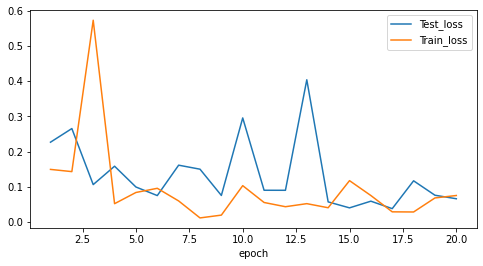

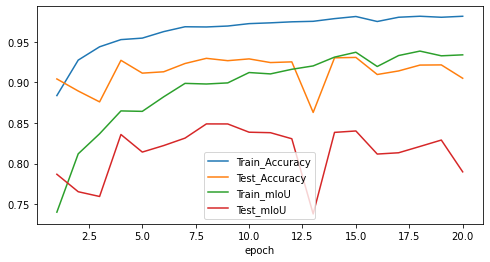

In [3]:
df.plot(x='epoch', y = ['Test_loss','Train_loss'], figsize=(8,4))
df.plot(x='epoch', y = ['Train_Accuracy', 'Test_Accuracy', 'Train_mIoU','Test_mIoU'], figsize=(8,4))

print('Results')
print(df[['Train_mIoU','Train_Accuracy']].max())
print('')
print(df[['Test_mIoU','Test_Accuracy']].max())

# Visualize predictions

#### with flowers 
0_cropped_181010_Pr_A_M06_1

#### medium vege
2_cropped_20200916_Ch_A_MA5_3
#### low vege
0_cropped_190913_Pr_A_M16_3
#### high vege
2_cropped_181010_Pr_D_M06_2

In [13]:
img_path = r'C:\Users\A60026184\Desktop\ModelB\DataAug\Test\Images\3_20200924_Ch_A_MA3_3.jpg'
#msk_path = r'C:\Users\A60026184\Desktop\DataAug20\Test\Masks\3_cropped_180926_Pr_A_M01_3.JPG'

In [5]:
# import augmenters from imgaug
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage

# Load the trained model 
baseline = torch.load(r'C:\Users\A60026184\Desktop\weights_Baug5_v0.pt')
baseline.eval()

print('DONE Loading models...')

DONE Loading models...


In [14]:
import torchvision.transforms as T

T_norm = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

T_tensor = T.Compose([
    T.ToTensor()
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def getPredict(a):
    pred =a['out'].data.cpu().numpy()
    return np.argmax(pred, axis=1)[0]

def get_segment_labels(image, model, device, transform):
    # transform the image to tensor and load into computation device
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image)
    return outputs

In [15]:
from PIL import Image

# read the image
image = Image.open(img_path)
# Read  a sample image and mask from the data-set
#mask = np.array(Image.open(msk_path))

#Get prediction 
## ---------------------  !!!!!! if trained on normalized !!!!!!! ----------------
a = get_segment_labels(image, baseline, device, T_norm)
#b = get_segment_labels(image, scheduler, device, T_norm)
#c = get_segment_labels(image, frozen, device, T_norm)
    

pred_a = getPredict(a)
#pred_b = getPredict(b)
#pred_c = getPredict(c)


# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
# Plot the input image, ground truth and the predicted output
#plt.figure(figsize=(15,3));

#plt.subplot(141);
#plt.hist(mask.flatten()/255)
#plt.title('Ground Truth')

#plt.subplot(142);
#plt.hist(pred_a.flatten())
#plt.title('Baseline')

### Print results

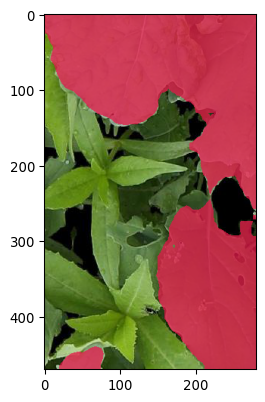

In [16]:
image = Image.open(img_path)
a = get_segment_labels(image, baseline, device, T_norm)
pred_a = getPredict(a)

# use imageio library to read the image (alternatively you can use OpenCV cv2.imread() function)
image = imageio.imread(img_path)


def makeSeg(image, mask):
    segmap = np.zeros(image.shape, dtype=bool)
    segmap[:,:,0] = mask
    segmap = SegmentationMapOnImage(segmap, shape=image.shape)
    
    return segmap

base_pred = makeSeg(image, pred_a)

results=[]
results.append(base_pred.draw_on_image(image)[0])
ia.imshow(ia.draw_grid(results, cols=1))

images_aug = base_pred.draw_on_image(image)[0]
imageio.imwrite(r'H:\Aurélie\Results\Pred\3_cropped_181022_Md_A_M20_1.JPG', images_aug)

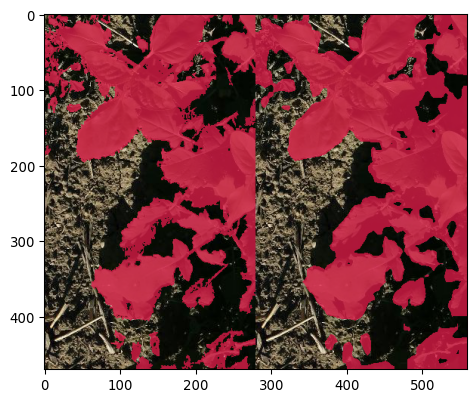

In [38]:
# use imageio library to read the image (alternatively you can use OpenCV cv2.imread() function)
image = imageio.imread(img_path)

# Open image with mask
pil_mask = Image.open(msk_path) 
pil_mask = pil_mask.convert("RGB")

# Convert mask to binary map
np_mask = np.array(pil_mask)
np_mask[np_mask > 150]=255
np_mask[np_mask<100]=0
np_mask = np.clip(np_mask, 0, 1)


def makeSeg(image, mask):
    segmap = np.zeros(image.shape, dtype=bool)
    segmap[:,:,0] = mask
    segmap = SegmentationMapOnImage(segmap, shape=image.shape)
    
    return segmap

segmap = makeSeg(image, np_mask[:,:,0])
base_pred = makeSeg(image, pred_a)
#sche_pred =  makeSeg(image, pred_b)
#froz_pred = makeSeg(image, pred_c)

results=[]
results.append(segmap.draw_on_image(image)[0])
for seg in [base_pred]:
    results.append(seg.draw_on_image(image)[0])
ia.imshow(ia.draw_grid(results, cols=2))

In [39]:
images_aug = seg.draw_on_image(image)[0]
mask = segmap.draw_on_image(image)[0]

imageio.imwrite('3_cropped_180926_Pr_A_M01_3.JPG', images_aug)
imageio.imwrite('3_cropped_180926_Pr_A_M01_3_mask.JPG', mask)

In [ ]:
def getPourcentage(a):
    return np.sum(a)/(a.shape[0]*a.shape[1])

def getGt(gt):
    return np.sum(gt[:,:,0])/(gt.shape[0]*gt.shape[1])

def getDiff(gt, a):
    p_gt = getGt(gt)
    diff = p_gt  - getPourcentage(a)
    return p_gt, diff

In [ ]:
for i in [pred_a, pred_b, pred_c]:
    p = getPourcentage(i)
    p_gt, diff = getDiff(np_mask, i)
    
    print('Vegetation coverage:', round(p*100,2), '%')
    print('Difference pourcentage to Ground Truhth is', round(diff*100,2),'%\n')

In [ ]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)
    
    label_map = [
               (0, 0, 0),  # background
               (255, 0, 0)] # vegetation
               #(0, 255, 0)] # bicycle
    
    for label_num in range(0, len(label_map)):
        index = labels == label_num
        red_map[index] = np.array(label_map)[label_num, 0]
        green_map[index] = np.array(label_map)[label_num, 1]
        blue_map[index] = np.array(label_map)[label_num, 2]
        
    segmented_image = np.stack([red_map, green_map, blue_map], axis=2)
    return segmented_image
plt.imshow(draw_segmentation_map(b['out']))